Optical model for Olympus 25x objective based on patent
==============================

This model is a high NA (~1), long working distance (8mm) multi-immersion objective based on a lens description in the patent literature. 
It would seem to be a fairly good match for the XLPN25X, but we can't know for certain. We modelled the lens to try and debug
some issues we had when trying to perform multi-colour confocal microscopy in cleared samples. The conclusion we came to based
on the comupations in here is that the objective (as described) is optimised for the wavelengths encountered when doing 2-photon
excitation, rather than the visible light lines we were using.

In addition to pyoptic2, this notebook requires:

- pandas (for reading xlsx)
- python-microscopy (for simulating PSFs - you can run the first bit of the notebook without this)

First we need to define our system and setup some utility functions

This example is moderately complex, both because the design has movable elements, but also because we do a bunch of post-processing of the 
data in the notebook, but should give some indication of what is achievable in a real-world use case. Some of this would be very hard to do
in conventional optical CAD packages.

In [11]:
#get plotting and numpy stuff
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [12]:
#import pyoptic stuff
from pyoptic2 import material
from pyoptic2.util import zemax, read_agf
import pandas as pd
import pyoptic2 as pyo

from pyoptic2.display import plot2d, plot_system2d

# work out where the example data is (for lens models, glasses etc ...)
example_dir = os.path.join(os.path.dirname(os.path.dirname(pyo.__file__)), 'examples')

In [13]:
#load glass models.
#we cheat and get the SCHOTT glasses by just reading a thorlabs lens
glasses = zemax.readZar(os.path.join(example_dir, 'AC254-100-A-Zemax.zar'))[1] #readZar returns [lens1, lens2, etc ...], glass_database

#supplement our glasses with the ohara catalog
ohara = read_agf.read_glasscat(os.path.join(example_dir, 'OHARA_180518.AGF'))
glasses.update(ohara['ohara_180518'])

detected 18 sections


In [14]:
#additional materials
air = material.Material(material.Material.REFRACT, 1.0)

#note that (according to the patent) the lens is designed for glycerol immersion
glycerol = material.CauchyGlass(material.Material.REFRACT, [1.45797, 0.00598*1e6, -0.00036*1e6])

#benzene is used as a proxy for mineral oil (otherwise unspecified)
benzene = material.AbbeGlass(material.AbbeGlass.REFRACT, nd = 1.4934, vd = 30.)

cyclohexane = material.AbbeGlass(material.AbbeGlass.REFRACT, nd = 1.4265, vd = 56.51)

silicone_oil = material.AbbeGlass(material.AbbeGlass.REFRACT, nd = 1.48, vd = 44.)

tsf = material.AbbeGlass(material.AbbeGlass.REFRACT, nd = 1.495, vd = 26.5)
ce3d = material.AbbeGlass(material.AbbeGlass.REFRACT, nd = 1.505, vd = 30.94)

In [15]:
#Load the lens data from an excel file
# this excell file has the surfaces, and the glasses (decribed in patent with nd, vd) replaced with their nearest catalog match
lens_data = pd.read_excel(os.path.join(example_dir, 'olympus25x.xlsx'))
lens_data

,Surface,r,d,Glass,nd,vd,notes
0,1,inf,d1,Glycerol,NaN,NaN,NaN
1,2,inf,d2,Glycerol,NaN,NaN,NaN
2,3,inf,2.6879,S-BSL7,NaN,NaN,NaN
3,4,-16.9025,3.0029,S-LAH58,NaN,NaN,NaN
4,5,-10.3698,0.2,air,NaN,NaN,NaN
5,6,inf,3.378,S-FPM2,NaN,NaN,NaN
6,7,-21.7452,0.2,air,NaN,NaN,NaN
7,8,23.5437,5.5835,S-FPM2,NaN,NaN,NaN
8,9,-37.5468,2,N-KZFS4,NaN,NaN,NaN
9,10,-97.3456,d10,air,NaN,NaN,NaN


In [16]:
#ditto for the tube lens
tlens_data = pd.read_excel(os.path.join(example_dir, 'olympus_tube.xlsx'))
tlens_data

,Surface,r,d,Glass,nd,vd,notes
0,1,95.2596,5.3317,N-PSK58,1.56907,71.30,N-PSK58
1,2,-116.2766,2.8267,N-ZK7,1.50847,61.19,NaN
2,3,80.4059,16.3504,air,NaN,NaN,NaN
3,4,92.0498,8.7567,S-FSL5,1.48749,70.23,NaN
4,5,-73.2447,4.8745,N-KZFS11,1.63775,42.41,NaN
5,6,-292.4080,NaN,air,NaN,NaN,NaN


In [17]:
#build a dictionary of glasses we are going to use when constructing the objective
lens_glasses = {}
for s in lens_data.Glass:
    g_data = glasses.get(s, None)
    if not g_data is None:
        g = zemax.Glass(g_data)
        lens_glasses[s] = g
        
for s in tlens_data.Glass:
    g_data = glasses.get(s, None)
    if not g_data is None:
        g = zemax.Glass(g_data)
        lens_glasses[s] = g
        
#add the RIs for air and our immersion
lens_glasses['air'] = air
lens_glasses['Glycerol'] = glycerol
#lens_glasses['Glycerol'] = benzene

print(lens_glasses.keys())

dict_keys(['S-BSL7', 'S-LAH58', 'S-FPM2', 'N-KZFS4', 'N-KZFS11', 'S-FPL53', 'S-NBH53', 'N-LASF44', 'N-PSK58', 'N-ZK7', 'S-FSL5', 'air', 'Glycerol'])


In [27]:
def _surface(radius, **kwargs):
    """ Helper function to choose a plane or spherical surface as appropriate - TODO move this to pyoptic code
    """
    if radius == inf:
        return pyo.PlaneSurface(**kwargs)
    else:
        return pyo.SphericalSurface(curvature_radius=radius, **kwargs)

        

def objective(d, pos, sph=2.5823, d2=7.95):
    """ Build an objective pointed in direction d, with a focus at pos (both numpy arrays)
        
        The objective has 4 movable surfaces (two glass elements cemented together) which translate within
        the lens to correct spherical abberation (RI mismatch). The sph parameter controlls the translation (in mm)
        of these elements, and represents the correction collar setting (or a potentially non-linear scaling thereof).
        
        The valid range in the model is 0.5:4.6 (although this might be more than the actual range permitted by the objective)
        
        Parameters
        ----------
        
        d : 3x1 ndarray (unit vector in direction of optical axis)
        pos: 3x1 ndarray (position of lens focus)
    """
    z0 = 0

    #the patent model has a number of parameters
    params = {'d1' : 0,  #focal plane position - do not change
              'd2' : d2,#7.95,#8.0500, #8.117,#  #distance from object to front lens surface
              'd10': sph,  #translation of spherical correction elements (passed as sph)
              'd14' : 4.6- sph #distance from final translating element to next fixed element
              }

    #loop over lens elements and create surfaces
    surfaces = []
    for i in range(0, len(lens_data)):
        glass = lens_glasses.get(lens_data.Glass[i], None)
        if glass is None:
            # if there is no glass name, create a custom glass with the specified nd and vd
            glass = material.AbbeGlass(material.Material.REFRACT, nd = lens_data.nd[i], vd = lens_data.vd[i])

        radius = lens_data.r[i]
        surfaces.append(_surface(radius=radius,
                                 name='Objective_%d'% (i+1),
                                 dimension=np.ones(3)*10.,
                                 placement=pyo.Placement(z0*d + pos,d),
                                 material=glass
                                ))

        # if the distance to the next lens is a variable parameter, get it from out params, else get it 
        # from the lens data
        dz = params.get(lens_data.d[i], None)
        if dz is None:
            dz = float(lens_data.d[i])

        if np.isnan(dz):
            dz = 0
        z0 += dz

    #print z0
    
    return surfaces

In [31]:
def t_lens(d, pos):
    """Create a tube lens as defined in the patent - as for the objective above"""
    z0 = 0
    t_surfaces = []
    params = {}
    
    for i in range(0, len(tlens_data)):
        glass = lens_glasses.get(tlens_data.Glass[i], None)
        if glass is None:
            glass = material.AbbeGlass(material.Material.REFRACT, nd = tlens_data.nd[i], vd = tlens_data.vd[i])

        radius = tlens_data.r[i]

        t_surfaces.append(_surface(radius,
                                  name='Tube_%d'% (i+1), 
                                  dimension=np.ones(3)*15.,
                                  placement=pyo.Placement((z0 - 0)*d + pos,d),
                                  material=glass))
        

        dz = params.get(tlens_data.d[i], None)
        if dz is None:
            dz = float(tlens_data.d[i])
        z0 += dz
        
    return t_surfaces
    

Testing our setup
==========

/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))


(-33.0, 33.0, -26.679998779296877, 560.2799743652344)

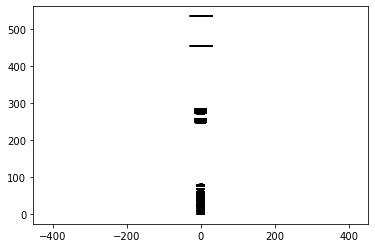

In [32]:
#create an optical system and add the objective, tube lens, and two camera planes (one at and one after the nominal focus)
#the point here is just a sanity check - do we actually create something which looks like an objective

# start at the origin
pos = np.zeros(3)

# and point along the +ve x axis
d = np.zeros(3)
d[0] = 1.0

s = pyo.System()
s.extend(objective(d, pos, 2.5823))
s.extend(t_lens(d, pos + (166+ 80)*d))

# put a surface just before the focal point (we will propagate rays from here to the true focus later on when generating PSFs etc ...)
s.append(pyo.PlaneSurface(name='pre-focal plane', 
                          dimension=np.ones(3)*30., 
                          placement=pyo.Placement((207.6 + (166 + 80))*d + pos,d), 
                          material=air))

# put a surface just behing the true point. This is just here so that the rays continue to propagate and we see what happens through the
# focus
s.append(pyo.PlaneSurface(name='post-focal plane', 
                          dimension=np.ones(3)*30., 
                          placement=pyo.Placement((207.6+80 + (166 + 80))*d + pos,d),
                          material=air))


/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))


(-33.0, 33.0, -26.679998779296877, 560.2799743652344)

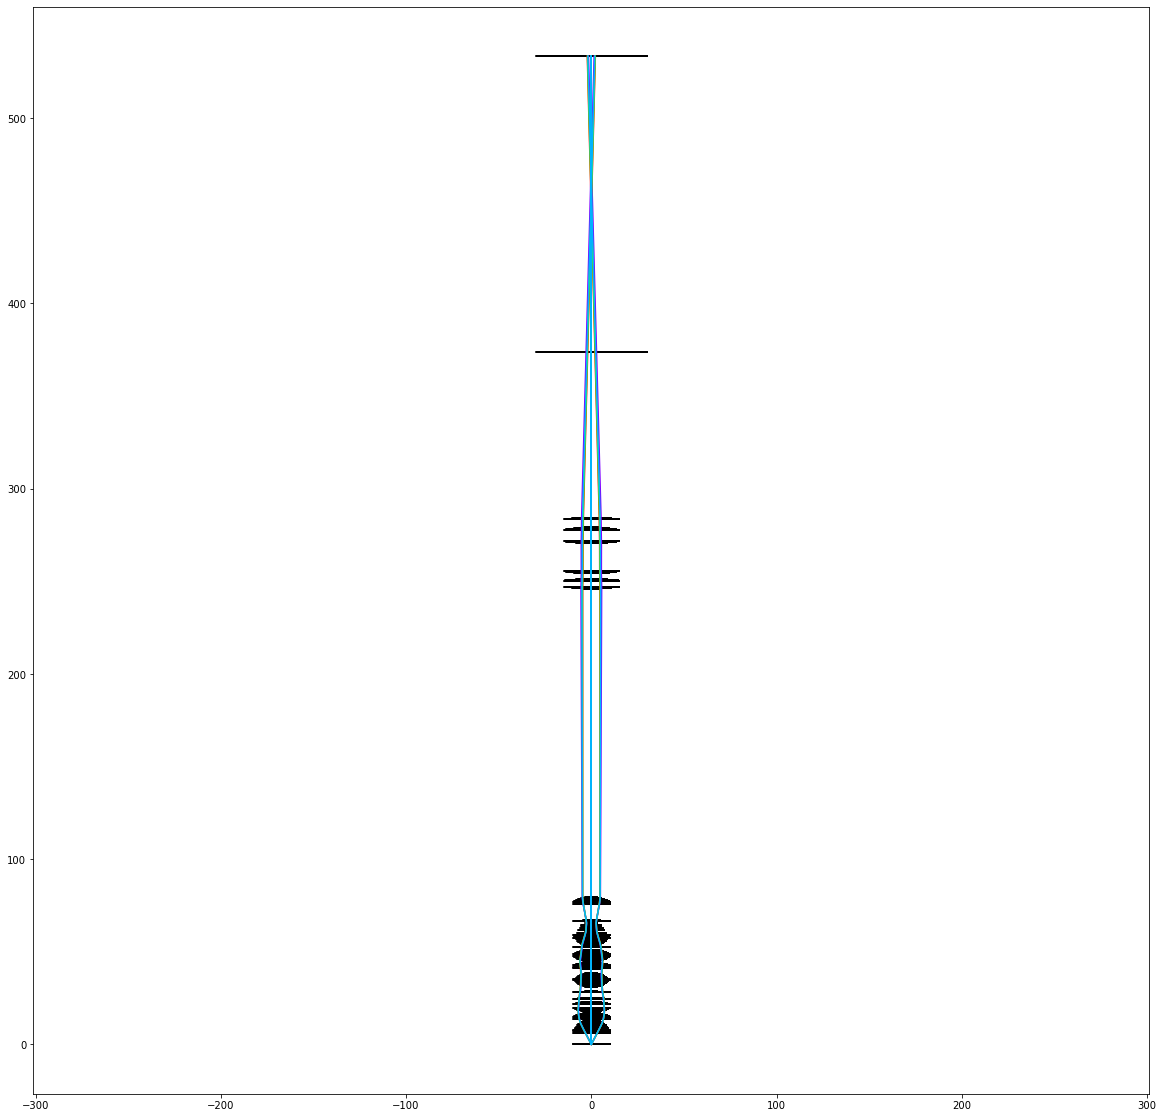

In [192]:
#generate a bunch of point sources on axis at the wavelengths we are interested in
src = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(1,0,0), wavelength=642.)
src4 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(0,.7,1), wavelength=488.)
src2 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.5,0,1), wavelength=405.)
src3 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=568.)

#generate some off axis sources at the same wavelengths (to test for field-dependant effects)
dx = 240e-3
src_a = pyo.PointSource('light source', pyo.Placement([0,dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(1,0,0), wavelength=642.)
src4_a = pyo.PointSource('light source', pyo.Placement([0, dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(0,.7,1), wavelength=488.)
src2_a = pyo.PointSource('light source', pyo.Placement([0, dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.5,0,1), wavelength=405.)
src3_a = pyo.PointSource('light source', pyo.Placement([0, dx, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=568.)

# generate point sources in the objective design range
src_800 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=800.)
src_900 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=900.)
src_1000 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(.3,1,0), wavelength=1000.)
#src4 = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(0,1,1), wavelength=900.)

#propagate the on-axis sources through the system and visually confirm that it's behaving as expected
figure(figsize=(20,20))
plot_system2d(s, 'xy')
plot2d(s.propagate(src.chief_rays), 'xy')
plot2d(s.propagate(src2.chief_rays), 'xy')
plot2d(s.propagate(src3.chief_rays), 'xy')
plot2d(s.propagate(src4.chief_rays), 'xy')

# optionally, propagate off axis sources as well
# plot2d(s.propagate(src_a.chief_rays), 'xy')
# plot2d(s.propagate(src2_a.chief_rays), 'xy')
# plot2d(s.propagate(src3_a.chief_rays), 'xy')
# plot2d(s.propagate(src4_a.chief_rays), 'xy')
axis('equal')

/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))


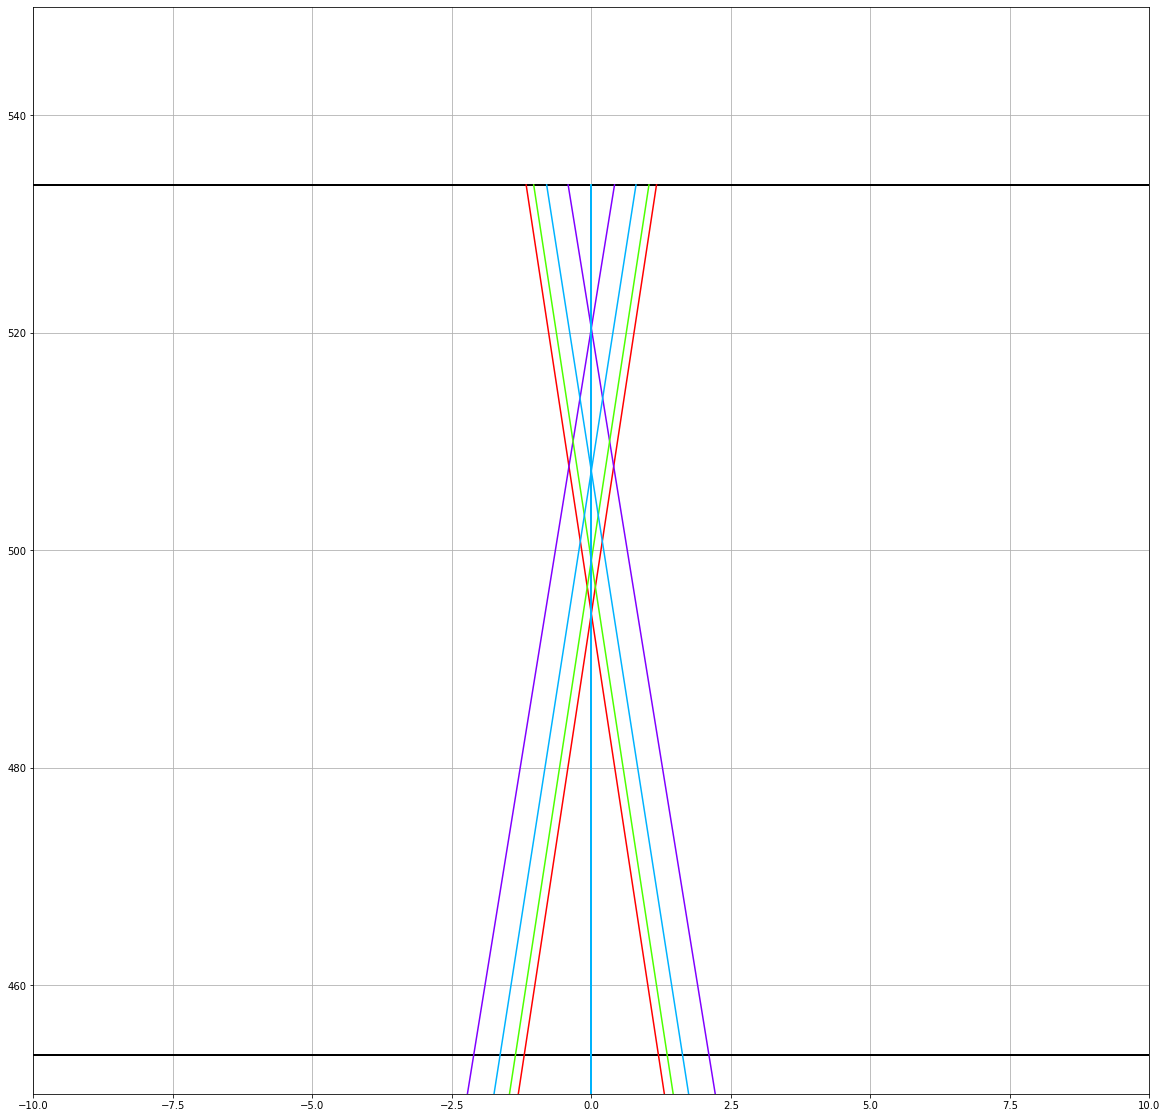

In [36]:
# a zoom in of the focus @642nm

figure(figsize=(20,20))
plot_system2d(s, 'xy')
plot2d(s.propagate(src.chief_rays), 'xy')
plot2d(s.propagate(src2.chief_rays), 'xy')
plot2d(s.propagate(src3.chief_rays), 'xy')
plot2d(s.propagate(src4.chief_rays), 'xy')

#plot2d(s.propagate(src_a.chief_rays), 'xy')
#plot2d(s.propagate(src2_a.chief_rays), 'xy')
#plot2d(s.propagate(src3_a.chief_rays), 'xy')
##plot2d(s.propagate(src4_a.chief_rays), 'xy')
#axis('equal')

xlim(-10,10)
ylim(450, 550)
grid()

More setup for a fully parameterized system
========================

To be able to assess system behaviour as a function of collar setting, we need a parameterized version of the whole system as tested above.
This parametisation consists of two parts:

a) the focal plane of the objective varies with the correction collar setting - we create a new objective definition which automatically sets the focal
   distance for each correction collar setting
   
b) create a function to generate the entire system as a function of correction collar setting


In [37]:
# error term to permit optimisation of d2 (objective-sample distance) for correction
# collar setting - assumes that light exiting objective should be collimated when focus is correct
def _foc_err(d2, corr_collar, wavelength=642.):
    s = pyo.System()
    pos = np.zeros(3)
    s.extend(objective(d, pos, corr_collar, d2=d2))
    
    src = pyo.PointSource('light source', pyo.Placement([0, 0, 0], [1, 0, 0]), NA=(1.0/1.47), color=(1,0,0), wavelength=wavelength)
    res = s.propagate(src.chief_rays)
    
    merit = (1-res[0][-1].d[1:,0]).sum()
    
    return(merit)
    

from scipy.optimize import fmin
#print(fmin(_foc_err, 8.0, (2.8,)))

# autofocussing objective definition
def objective_rf(d, pos, corr_collar):
    d2 = float(fmin(_foc_err, 8.0, (corr_collar,), disp=False))
    #print('d2: %3.3f' % d2)
    return objective(d, pos, corr_collar, d2=d2)

In [103]:
def gen_system(corr_collar=2.5823):
    """Generate a parameterized version of the microscope system
    
    NOTE: our first camera plane is deliberately in front of where we expect our image to be formed as we will calculate
    the optimal focus of the raybundle as it passes this plane and propagate our beam to this optimal focus before
    calculating metrics
    """
    s = pyo.System()
    pos = np.zeros(3)
    s.extend(objective_rf(d, pos, corr_collar))
    
    s.extend(t_lens(d, pos + (166+ 80)*d))
        
    s.append(pyo.PlaneSurface(name='camera', 
                              dimension=np.ones(3)*30., 
                              placement=pyo.Placement((207.6 - 80 + (166 + 80))*d + pos,d), 
                              material=air))
    s.append(pyo.PlaneSurface(name='camera', 
                              dimension=np.ones(3)*30., 
                              placement=pyo.Placement((207.6+80 + (166 + 80))*d + pos,d), 
                              material=air))
    
    return s

/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: RuntimeWarning: invalid value encountered in sqrt
  zz = np.sign(self.radcurv)*(-np.sqrt(self.radcurv**2-xx**2-yy**2) +np.abs(self.radcurv))
/Users/david/pyoptic-2/pyoptic2/elements.py:200: R

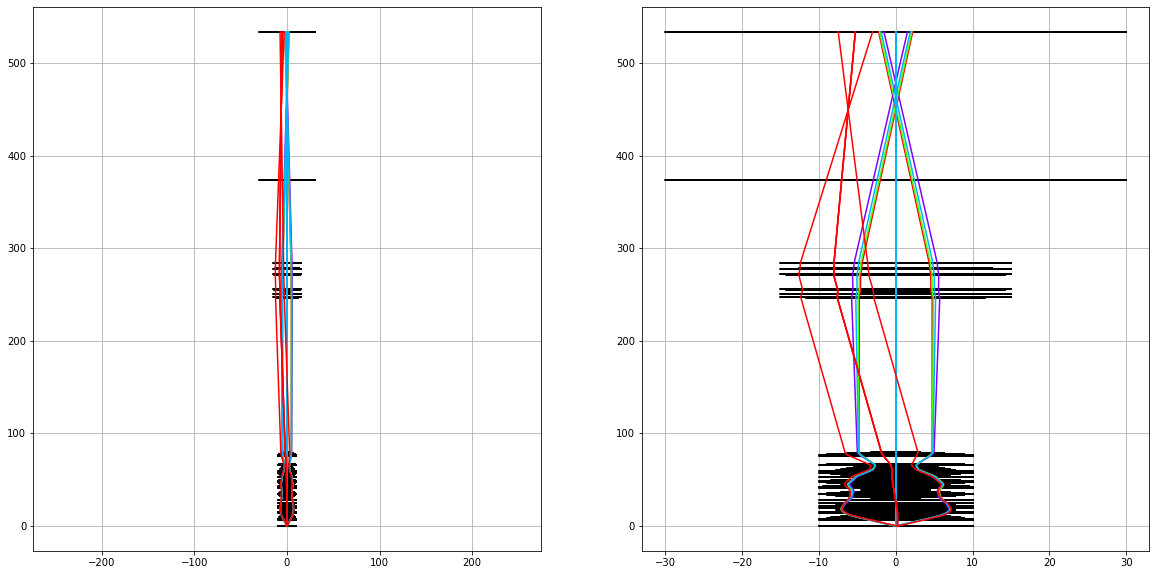

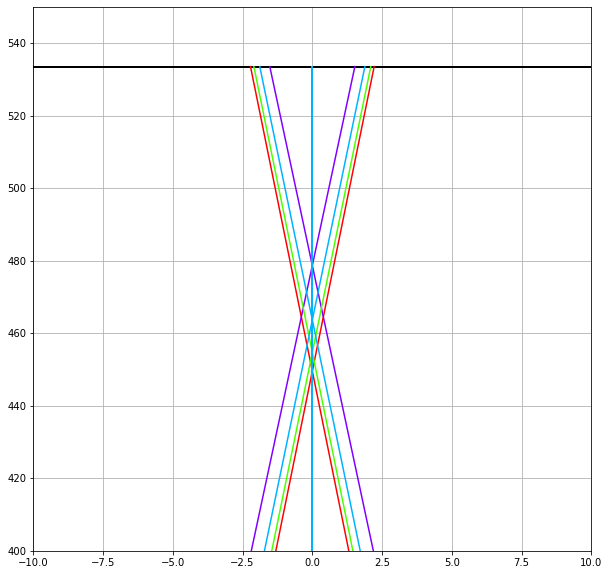

In [196]:
# a zoom in of the focus @642nm
lens_glasses['Glycerol'] = glycerol
s = gen_system(corr_collar=3.2)

#propagate the on-axis sources through the system and visually confirm that it's behaving as expected
figure(figsize=(20,10))
subplot(121)
plot_system2d(s, 'xy')
plot2d(s.propagate(src.chief_rays), 'xy')
plot2d(s.propagate(src2.chief_rays), 'xy')
plot2d(s.propagate(src3.chief_rays), 'xy')
plot2d(s.propagate(src4.chief_rays), 'xy')

plot2d(s.propagate(src_a.chief_rays), 'xy')
#plot2d(s.propagate(src2_a.chief_rays), 'xy')
#plot2d(s.propagate(src3_a.chief_rays), 'xy')
#plot2d(s.propagate(src4_a.chief_rays), 'xy')
axis('equal')
grid()

subplot(122)
plot_system2d(s, 'xy')
plot2d(s.propagate(src.chief_rays), 'xy')
plot2d(s.propagate(src2.chief_rays), 'xy')
plot2d(s.propagate(src3.chief_rays), 'xy')
plot2d(s.propagate(src4.chief_rays), 'xy')

plot2d(s.propagate(src_a.chief_rays), 'xy')
#plot2d(s.propagate(src2_a.chief_rays), 'xy')
#plot2d(s.propagate(src3_a.chief_rays), 'xy')
#plot2d(s.propagate(src4_a.chief_rays), 'xy')
#axis('equal')
grid()

figure(figsize=(10,10))
plot_system2d(s, 'xy')
plot2d(s.propagate(src.chief_rays), 'xy')
plot2d(s.propagate(src2.chief_rays), 'xy')
plot2d(s.propagate(src3.chief_rays), 'xy')
plot2d(s.propagate(src4.chief_rays), 'xy')

xlim(-10,10)
ylim(400, 550)
grid()



Emperical PSF apperance
-----------------------

In [197]:
# code to generate a PSF based on our propagated rays. We determine where our ray bundle will focus, propagate there, look at the
# relative phases of all the rays, and then interpolate these to form a complex pupil image, from which we can calculate the distribution
# of intensity in the focus.

# NB: This requires python-microscopy to be installed

from PYME.misc import zernike
from PYME.Analysis.PSFGen import fourierHNA
import matplotlib as mpl

def pupil(rays, prop_to_focus=True):
    rs = rays[-2]
    focus = float(rs.focus)
    
    if prop_to_focus:
        lam = abs((((rs.p0[0,:] + focus*rs.d[0,:]) -rs.p0)*(rs.d[0,:][None,:])).sum(-1)/(rs.d*rs.d[0,:][None,:]).sum(-1))
        rs.p1 = rs.propagate(lam)
    
    pathlengths = rs.cumulativePath/(rays[0].wavelength*1e-6)
    pathlengths -= pathlengths.mean()

    kx, ky = rays[0].d[:,1:].T
    
    kc = kx + 1j*ky
    
    theta = angle(kc)
    r = abs(kc)
    r = r/r.max()
    
    coeffs, res, p = zernike.calcCoeffs_rays(r, theta, pathlengths, 35)
    strehl = 1 - (4*np.pi**2)*(np.array(coeffs[4:])**2).sum()
    
    return kx, ky, pathlengths, coeffs, strehl

def phase_plot(rays, prop_to_focus=True):
    kx, ky, pathlengths, coeffs, strehl = pupil(rays, prop_to_focus)
    
    #print('Predicted Strehl ratio: %f' % strehl)
    
    f = figure(figsize=(15, 3))
    subplot(141)
    scatter(kx, ky, c=pathlengths, edgecolor='none', norm=mpl.colors.SymLogNorm(0.1, 0.1), cmap='seismic', vmin=-10, vmax=10)
    axis('equal')
    axis('off')
    colorbar(label='Path error/$\lambda$', ticks=[-10, -1, 0, 1, 10])
    title('Pupil')
    
    subplot(142)
    bar(arange(len(coeffs)), coeffs)
    grid()
    ylim(1.5*min(coeffs[3:]), 1.5*max(coeffs[3:]))
    title('Zernike modes')
    
    # now simulate some PSFs - these are done in image space (hence NA/25 and a few other scaling factors), but the same 
    # Zernike mode info could also be used to simulate in object space and correctly capture apodisation, polarization, and other high-NA effects 
    
    # convert Zernike amplitudes from wavelengths to radians
    zcoeffs = {n: 2*pi*coeffs[n] for n in range(3, len(coeffs))}
    
    # XY slice
    subplot(143)
    
    #pixel size
    dx = 3e3

    ps = fourierHNA.GenZernikeDPSF([0], dx=dx, X=dx*np.arange(-100, 100, 1.), Y = dx*np.arange(-100, 100, 1.), 
                              zernikeCoeffs=zcoeffs, lamb=600, n=1, NA=(1.0/1.47)/25., apodizisation='sine', output_shape = [15, 15, 1])
    imshow(ps.squeeze(), interpolation='nearest', cmap='hot')
    axis('off')
    pr = ps.squeeze().sum(1)
    fwhm_x = (dx*(pr > (pr.max()/2.0)).sum()/25)
    title(f'XY ($FWHM_x={fwhm_x:.1f}$)')
    
    #xz slice - simulate a slightly larger stack in this case and crop down
    a = subplot(144)
    ps = fourierHNA.GenZernikeDPSF(120*(25**2)*np.arange(-30, 31), dx=dx, X=dx*np.arange(-100, 200, 1.), Y = dx*np.arange(-100, 100, 1.), 
                              zernikeCoeffs=zcoeffs, lamb=600, n=1, NA=(1.0/1.47)/25., apodizisation='sine', output_shape = [30, 30, 61])
    
    
    a.imshow(ps[15,:,:].squeeze().T, interpolation='nearest', cmap='hot')
    a.set_axis_off()
    a.set_title('XZ')
    
    return ps

/Users/david/opt/miniconda3/envs/pyme37/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


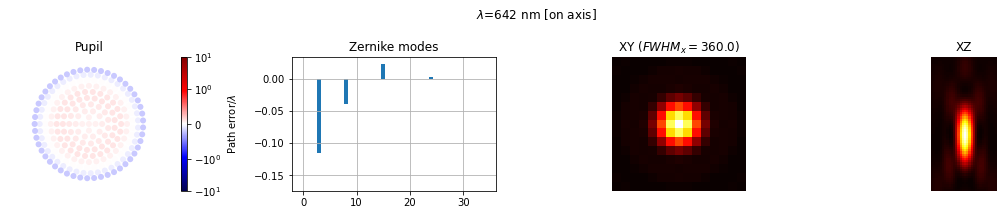

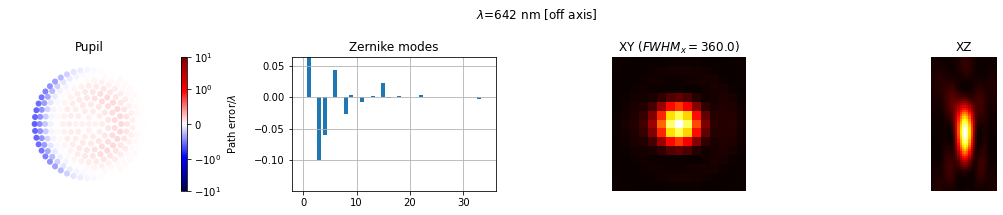

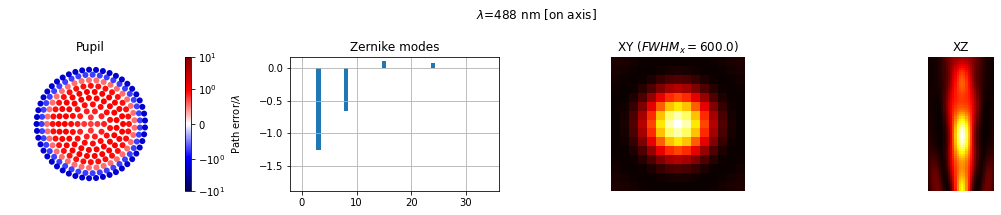

In [198]:
# Generate PSFs for a variety of configurations

# CHANGEME: if we want to change our immersion, we can overwrite the 'Glycerol' entry in our local copy of the glass database
# before generating the system
lens_glasses['Glycerol'] = glycerol
#lens_glasses['Glycerol'] = tsf
#lens_glasses['Glycerol'] = benzene
#lens_glasses['Glycerol'] = cyclohexane
#lens_glasses['Glycerol'] = silicone_oil

# CHANGEME: Generate a system with the desired correction collar setting
s = gen_system(2.6)

# 642nm, on axis
r = s.propagate(src.pupil_rays)
phase_plot(r[0], True)
suptitle('$\\lambda$=642 nm [on axis]')
gcf().tight_layout()

# 642nm, off axis
r = s.propagate(src_a.pupil_rays)
phase_plot(r[0], True)
suptitle('$\\lambda$=642 nm [off axis]')
gcf().tight_layout()

# 488nm, on axis
r = s.propagate(src4.pupil_rays)
phase_plot(r[0], True)
suptitle('$\\lambda$=488 nm [on axis]')
gcf().tight_layout()

/Users/david/opt/miniconda3/envs/pyme37/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


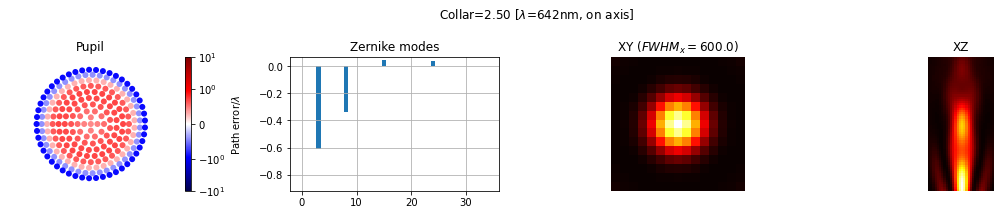

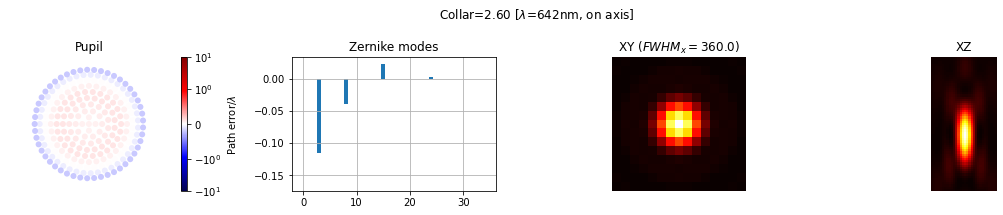

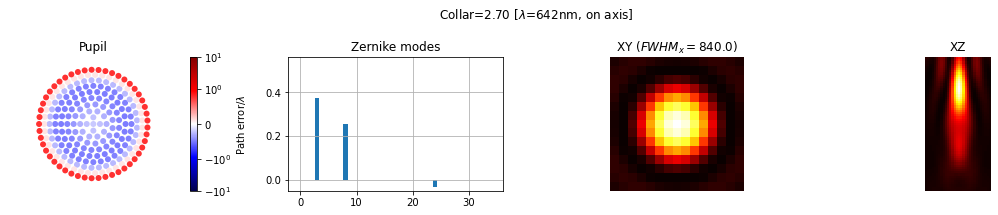

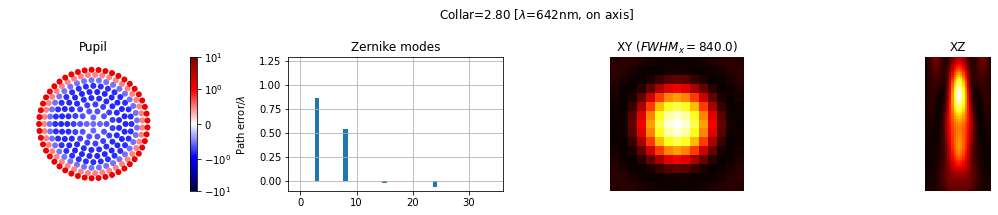

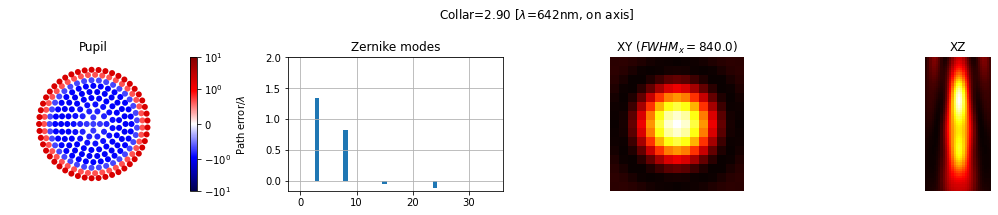

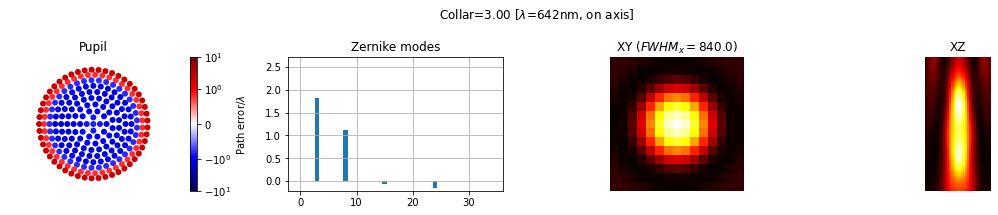

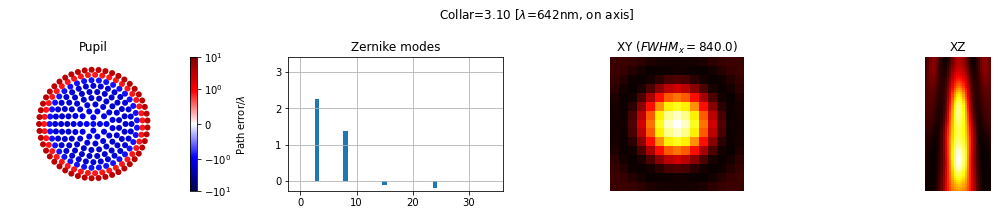

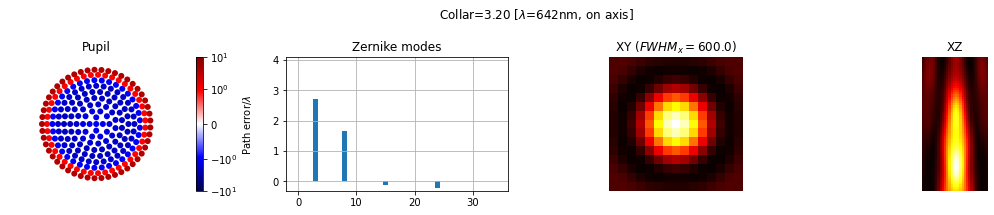

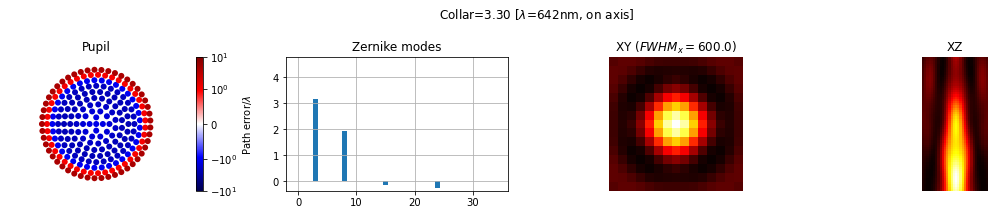

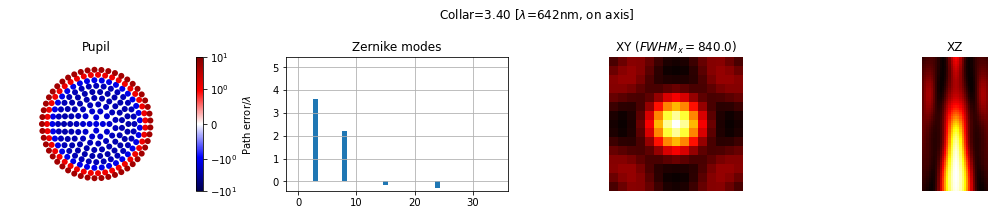

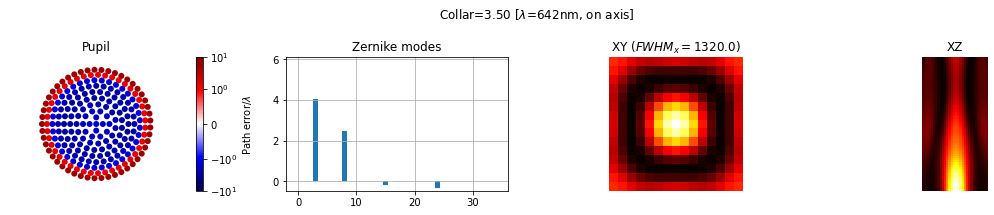

In [189]:
# Generate PSFs at 642 for a range of correction collar settings to see how quickly they go bad
# take home message: even an increment or 0.1 on the sacle from 0.5-4.6 is too much.

for xc in arange(2.5, 3.51, .1):
    s = gen_system(xc)
    r = s.propagate(src.pupil_rays)
    phase_plot(r[0], True)
    suptitle(f'Collar={xc:.2f} [$\lambda$=642nm, on axis]')
    gcf().tight_layout()

Now for some more quantitative metrics

Focal shift between colours
--------------------------

Quantify the relative focal shift between colours. 

**NOTE:** shifts are relative, not absolute, and are based on moving the camera, not moving the sample.

In [170]:
def focal_shift(corr_collar=2.5823):
    """
    Estimate focal shifts using extreme rays only
    """
    s = gen_system(corr_collar)
    
    return (s.propagate(src.chief_rays)[0][-2].focus,  
        s.propagate(src2.chief_rays)[0][-2].focus, 
        s.propagate(src3.chief_rays)[0][-2].focus,
        s.propagate(src4.chief_rays)[0][-2].focus, 
            s.propagate(src_800.chief_rays)[0][-2].focus,
            s.propagate(src_900.chief_rays)[0][-2].focus,
            s.propagate(src_1000.chief_rays)[0][-2].focus,
           )

def focal_shift2(corr_collar=2.5823):
    """
    Estimate focal shifts using average of pupil
    """
    s = gen_system(corr_collar)
    
    return (s.propagate(src.pupil_rays)[0][-2].focus,  
        s.propagate(src2.pupil_rays)[0][-2].focus, 
        s.propagate(src3.pupil_rays)[0][-2].focus,
        s.propagate(src4.pupil_rays)[0][-2].focus, 
            s.propagate(src_800.pupil_rays)[0][-2].focus,
            s.propagate(src_900.pupil_rays)[0][-2].focus,
            s.propagate(src_1000.pupil_rays)[0][-2].focus,
           )

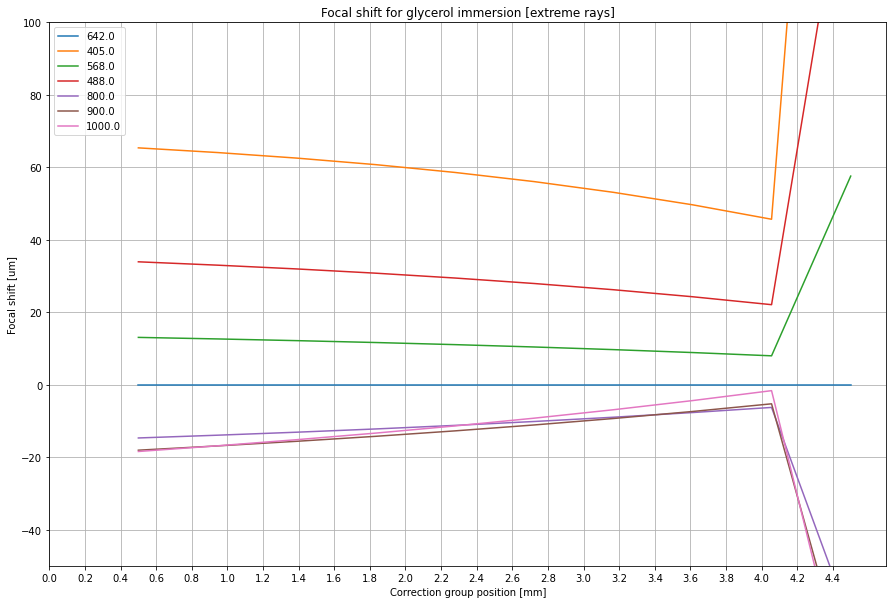

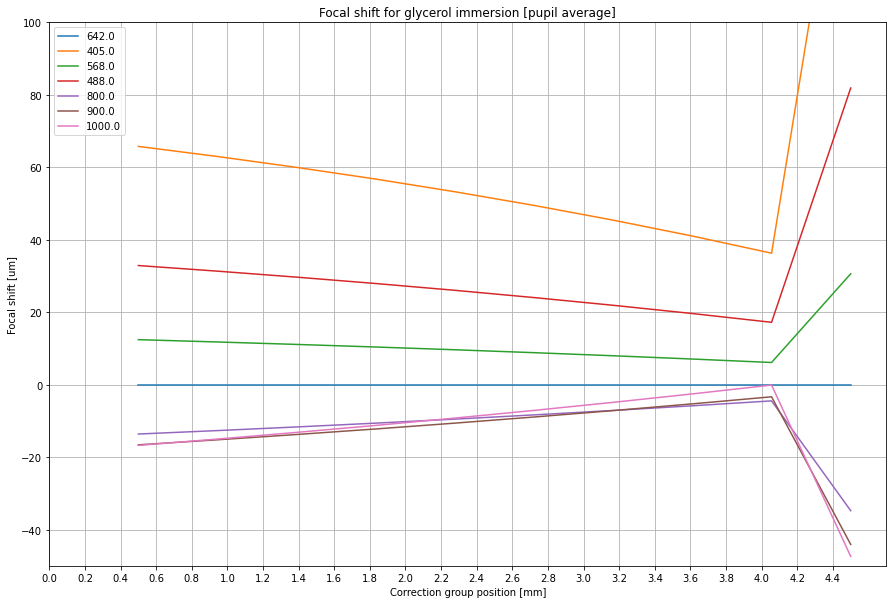

In [200]:
# Focal shift for glycerol immersion
lens_glasses['Glycerol'] = glycerol

# a range of collar settings to evaluate over
f_coll = linspace(0.5, 4.5, 10)

shifts = 1e3*(np.array([focal_shift(c) for c in f_coll]))/625. #625 = 25^2 (convert axial shift from camera to object space)

figure(figsize=(15, 10))
plot(f_coll, shifts - shifts[:,0][:,None])
grid()
_ = xticks(np.arange(0, 4.6, .2))
xlabel('Correction group position [mm]')
ylabel('Focal shift [um]')
ylim(-50, 100)
title('Focal shift for glycerol immersion [extreme rays]')
legend([s_.wavelength for s_ in [src, src2, src3, src4, src_800, src_900, src_1000]])

shifts = 1e3*(np.array([focal_shift2(c) for c in f_coll]))/625. #625 = 25^2 (convert axial shift from camera to object space)
figure(figsize=(15, 10))
plot(f_coll, shifts - shifts[:,0][:,None])
grid()
_ = xticks(np.arange(0, 4.6, .2))
xlabel('Correction group position [mm]')
ylabel('Focal shift [um]')
ylim(-50, 100)
title('Focal shift for glycerol immersion [pupil average]')
legend([s_.wavelength for s_ in [src, src2, src3, src4, src_800, src_900, src_1000]])


Abberations
-----------

We quantify our abberations in two ways - the amplitude of the zernike mode (mode #8) corresponding to spherical
abberation, which is the abberation mode most effected by RI mismatch, and by the Strehl ratio - the ratio of the peak PSF brightness to that of an unabberated PSF.


In [164]:
def collar_zerns(corr_collar=2.5823):
    s = gen_system(corr_collar)
    
    return [pupil(s.propagate(s_.pupil_rays)[0])[3] for s_ in [src, src2, src3, src4, src_800, src_900, src_1000]]

def collar_strehl(corr_collar=2.5823):
    s = gen_system(corr_collar)
    
    return [pupil(s.propagate(s_.pupil_rays)[0])[4] for s_ in [src, src2, src3, src4, src_800, src_900, src_1000]] 

### Spherical abberation (Zernike mode 8)

*Note:* The optimal value is 0. A mode amplitude (absolute value) of 1 is already "bad", with things starting to get visibly abberated at a Zernike amplitude of about 0.2-0.3.

Text(0.5, 1.0, 'Spherical abberation (Zernike 8) - glycerol')

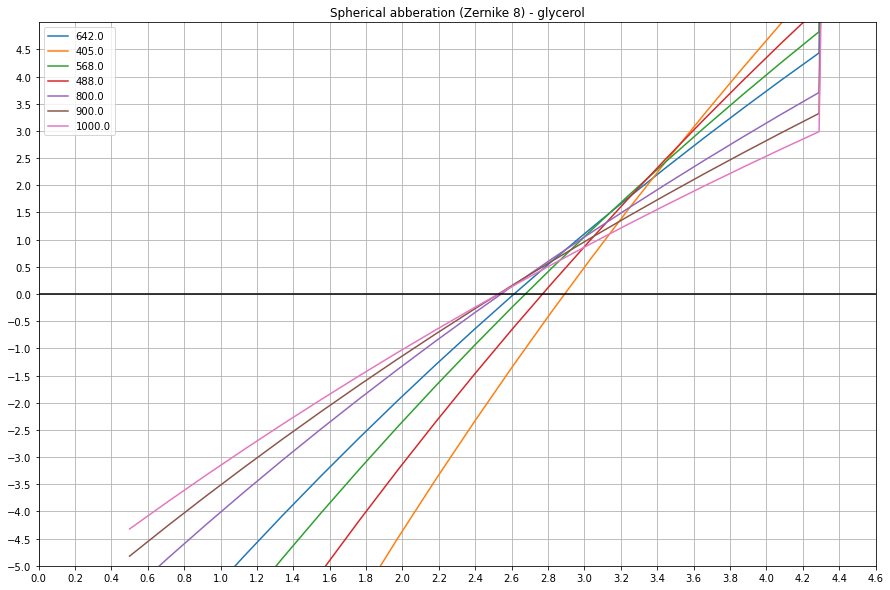

In [202]:
lens_glasses['Glycerol'] = glycerol

f_coll = linspace(0.5, 4.5, 20)
zerns = np.array([np.array(collar_zerns(c))[:,8] for c in f_coll])

figure(figsize=(15, 10))
plot(f_coll, zerns.squeeze())
plot([0,4.6], [0,0], 'k')
grid()
legend([s_.wavelength for s_ in [src, src2, src3, src4, src_800, src_900, src_1000]])
xlim(0.5, 4.6)
ylim(-5,5)
_ = xticks(np.arange(0, 4.61, .2))
_ = yticks(np.arange(-5, 5, .5))
title('Spherical abberation (Zernike 8) - glycerol')

### Strehl ratio

This measures how good the PSF is compared to a diffraction limited PSF. The optimal is 1, with anyting over ~0.8 being considered to be good. 

*Caveat: we estimate the Strehl ratio from the Zernike mode amplitudes and this is unreliable for badly abberated PSFs*

Text(0.5, 1.0, 'Strehl ratio - glycerol')

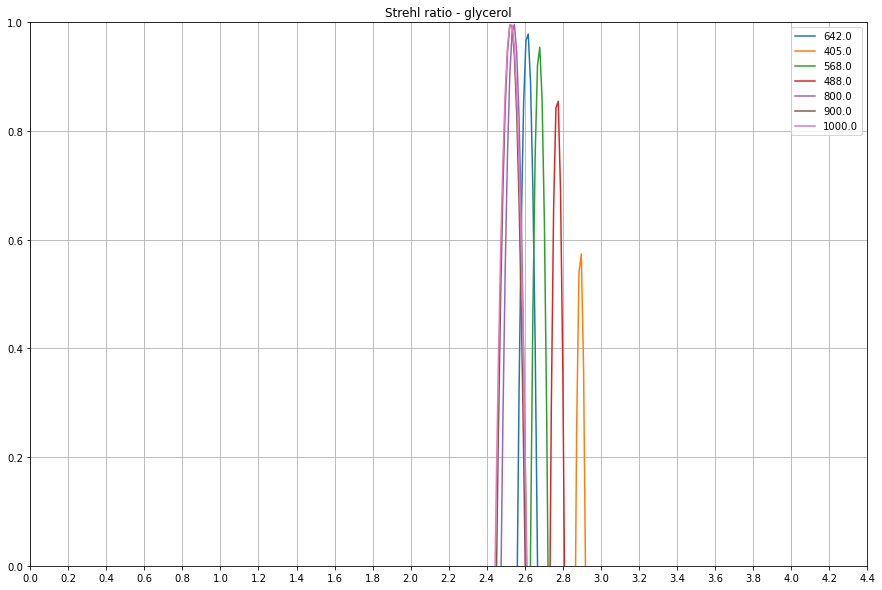

In [166]:
lens_glasses['Glycerol'] = glycerol
f_coll = linspace(2.0, 3.2, 100) # NB range restricted for performance - alter if altering media

strehls = np.array([np.array(collar_strehl(c)) for c in f_coll])

figure(figsize=(15, 10))
plot(f_coll, strehls.squeeze())
grid()
legend([s_.wavelength for s_ in [src, src2, src3, src4, src_800, src_900, src_1000]])
ylim(0,1)
_ = xticks(np.arange(0, 4.6, .2))
#_ = yticks(np.arange(-5, 5, .5))
title('Strehl ratio - glycerol')
